In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
import math
import pytorch_lightning as pl
# import lightning as pl
from glob import glob

from torch.utils.data import DataLoader, Subset
import torchvision.utils as vutils
from torchvision.transforms import v2

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

from skimage import io

pl.seed_everything(42)

Seed set to 42


42

In [2]:
IMG_SIZE = 64
BATCH_SIZE = 128

In [3]:
# gray = transforms.Compose([transforms.Grayscale(3)])
# half = transforms.Compose([transforms.Resize((IMG_SIZE/2, IMG_SIZE/2))])
# full = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE))])

In [4]:
reverse_transforms_img = transforms.Compose([
    transforms.Lambda(lambda t: (t+1) / 2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),
    transforms.Lambda(lambda t: (t * 255).clamp(0.1, 254.9)),
    transforms.Lambda(lambda t: np.clip(t.clamp(0.1, 254.9).numpy(), 0.1, 254.9).astype(np.uint8)),
    transforms.ToPILImage(),
])

reverse_transforms_tensor = transforms.Compose([
    transforms.Lambda(lambda t: (t+1) / 2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),
    transforms.Lambda(lambda t: (t * 255).clamp(0.1, 254.9)),
    transforms.Lambda(lambda t: np.clip(t.clamp(0.1, 254.9).numpy(), 0.1, 254.9).astype(np.uint8)),
    transforms.ToTensor(),
])

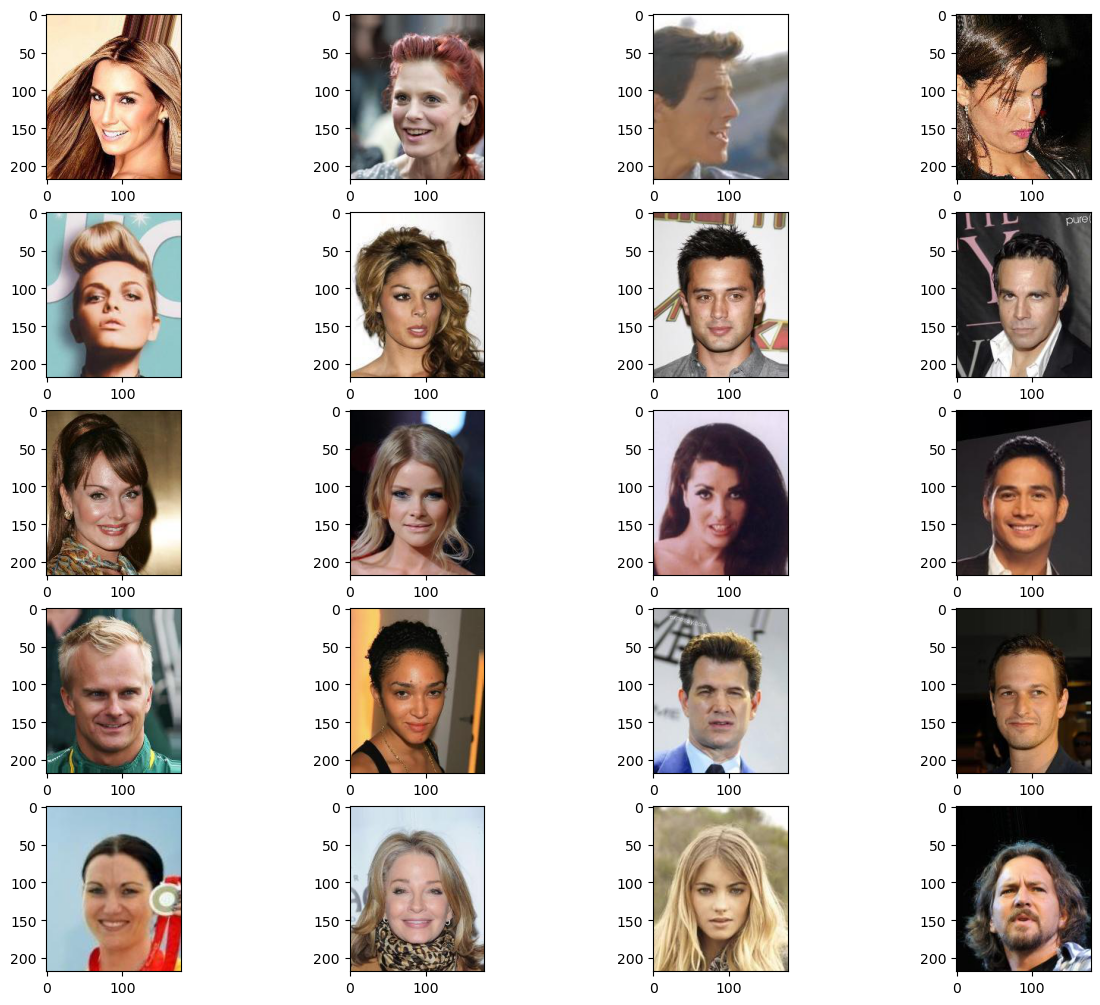

In [5]:
def show_images(datset, num_samples=20, cols=4):
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

# data = torchvision.datasets.ImageFolder(root="/home/maxim/Downloads/archive (4)")
data = torchvision.datasets.ImageFolder(root="/home/maxim/Documents/TestProject/gans/Face/img_align_celeba")
show_images(data)

In [6]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

T = 300
betas = linear_beta_schedule(timesteps=T)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [7]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: ((t * 2) - 1)) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    # train = torchvision.datasets.ImageFolder(root="/home/maxim/Documents/TestProject/maxim-lightning/archive (4)",
    #                                      transform=data_transform)
    train = torchvision.datasets.ImageFolder(root="/home/maxim/Documents/TestProject/gans/Face/img_align_celeba",
                                         transform=data_transform)
    return train
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: ((t + 1) / 2).clamp(min=-1, max=1)),
        transforms.Lambda(lambda t: t.permute(1, 2, 0).clamp(min=-1, max=1)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: np.clip(t.numpy(), 0.1, 254.9)),
        transforms.Lambda(lambda t: np.clip(t, 0.1, 254.9).astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/tmp/ipykernel_4254/492072164.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


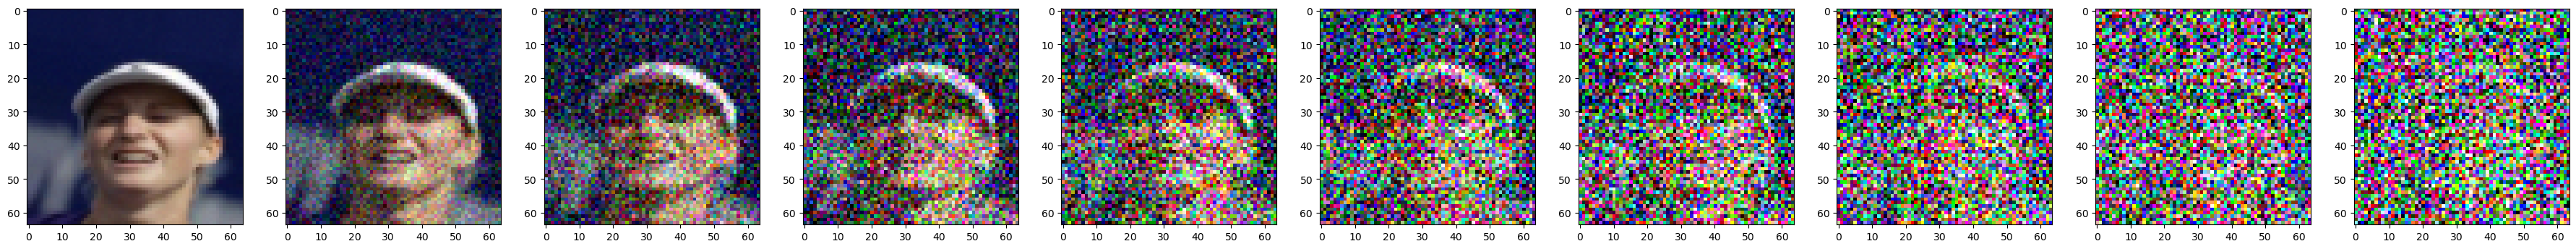

In [8]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(50,50))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [9]:
# class UBlock(nn.Module):
#     def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
#         super().__init__()
#         self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
#         if up:
#             self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
#             self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
#         else:
#             self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
#             self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
#         self.bnorm1 = nn.BatchNorm2d(out_ch)
#         self.bnorm2 = nn.BatchNorm2d(out_ch)
#         self.relu  = nn.ReLU()
        
#     def forward(self, x, t, ):
#         h = self.bnorm1(self.relu(self.conv1(x)))
#         time_emb = self.relu(self.time_mlp(t))
#         time_emb = time_emb[(..., ) + (None, ) * 2]
#         h = h + time_emb
#         h = self.bnorm2(self.relu(self.conv2(h)))
#         return self.transform(h)

In [10]:
# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         return embeddings

In [11]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, "cuda")
    # print("x_noisy nan: " + (torch.isnan(x_noisy.view(-1)).sum().item()==0).__str__())
    # print("noise nan: " + (torch.isnan(x_noisy.view(-1)).sum().item()==0).__str__())
    noise_pred = model(x_noisy, t)
    # print((torch.isnan(noise_pred.view(-1)).sum().item()==0).__str__())
    return F.l1_loss(noise, noise_pred)

In [12]:
@torch.no_grad()
def sample_timestep(model, x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image(model):
    img_size = IMG_SIZE
    
    img = torch.randn((1, 3, img_size, img_size), device="cuda")
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device="cuda", dtype=torch.long)
        img = sample_timestep(model, img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

In [13]:
from torch import nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings
    
class Unet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        self.val_outputs = []
        self.step = 0

        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])

        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)
    
    def prepare_data(self):
        transform = transforms.Compose(
            [
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                transforms.ToTensor(),
            ]
        )

        end_train_idx = int(len(dataloader.dataset) - len(dataloader.dataset) / 5)
        end_val_idx = int(len(dataloader.dataset) - len(dataloader.dataset) / 7)
        end_test_idx = len(dataloader.dataset)

        self.train_dataset = Subset(dataloader.dataset, range(0, end_train_idx))
        self.val_dataset = Subset(dataloader.dataset, range(end_train_idx + 1, end_val_idx))
        self.test_dataset = Subset(dataloader.dataset, range(end_val_idx + 1, end_test_idx))

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=20
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=BATCH_SIZE, num_workers=20
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=1, num_workers=20
        )
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0007)

    def training_step(self, batch, batch_idx):
        x0 = batch[0]
        n = len(x0)
        
        t = torch.randint(0, T, (n,), device="cuda")
        
        loss = get_loss(self, batch[0], t)

        self.step += 1

        if self.step % 750 == 0:
            sample_plot_image(self)
            print(f"Step {self.step:03d} | Loss: {loss.item()}")
            
            dict = self.state_dict()

            dict["pytorch-lightning_version"] = '2.1.0'
            dict["global_step"] = 0
            dict["epoch"] = 0
            dict["state_dict"] = self.state_dict()
            print(dict["global_step"])
            torch.save(dict, "diffusion_model_" + self.step.__str__() + ".ckpt")

        logs = {"loss": loss}
        return {"loss": loss, "log": logs}
    
    def validation_step(self, batch, batch_idx):
        x = batch[0]
        n = len(x)

        t = torch.randint(T-50, T, (n,), device="cuda").long()

        output = self(x, t)
        
        loss = get_loss(self, batch[0], t)

        output_img = output[0].cpu()

        self.val_outputs.append(reverse_transforms_tensor(output_img))

        self.log("val loss", loss)

        logs = {"loss": loss}
        return {"loss": loss, "log": logs}
    
    def on_validation_epoch_end(self):
        grid = vutils.make_grid(self.val_outputs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)
        # self.logger.close()

        self.val_outputs.clear()

        # grid = vutils.make_grid(self.val_outputs)
        # self.logger.add_image("generated_images", grid, self.current_epoch)
        # self.logger.close()

        # self.val_outputs.clear()

    # def on_train_epoch_end(self):
    #     print("Epoch " + self.current_epoch.__str__() + " Done")

    # def on_train_batch_start(self):
    #     print("Step " + self.current_step.__str__() + "/" + self.max_step.__str__())
    
model = Unet()
model

Unet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Co

In [14]:
trainer = pl.Trainer(max_epochs=100, precision='16-mixed', accelerator="cuda")

# model = Unet.load_from_checkpoint('/home/maxim/Documents/TestProject/maxim-lightning/diffusion_model.ckpt')

trainer.fit(model)
trainer.validate(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | time_mlp | Sequential | 1.1 K 
1 | conv0    | Conv2d     | 1.8 K 
2 | downs    | ModuleList | 41.2 M
3 | ups      | ModuleList | 21.3 M
4 | output   | Conv2d     | 195   
----------------------------------------
62.4 M    Trainable params
0         Non-trainable params
62.4 M    Total params
249.756   Total estimate

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/home/maxim/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val loss            0.1343272626399994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val loss': 0.1343272626399994}]

In [ ]:
# @torch.no_grad()
# def sample_plot_image(model, x_0):
#     imgs = []

#     img_noise, img = forward_diffusion_sample(x_0, torch.Tensor([0]).type(torch.int64))
#     for t in range(T):
#         img = model.forward(img, torch.Tensor([t]).type(torch.int64))
#         imgs.append(img[0].cpu())
#         print("t " + t.__str__() + " done!")

#     # reverse_transforms = v2.Compose([
#     #         transforms.Lambda(lambda t: (t + 1) / 2),
#     #         transforms.Lambda(lambda t: t.permute(1, 2, 0)),
#     #         transforms.Lambda(lambda t: t * 255.),
#     #         transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
#     #         transforms.ToTensor()
#     # ])

#     return imgs

In [ ]:
# for idx in range(0, T, stepsize):
#     t = torch.Tensor([idx]).type(torch.int64)
#     plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
#     img, noise = forward_diffusion_sample(image, t)
#     show_tensor_image(img)

In [ ]:
imgs = sample_plot_image(model.cuda())

In [ ]:
# show_tensor_image()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/